# Exploring Zero-Shot Classification with CLIP on CIFAR-100

**Zero-Shot Classification** is maybe one of the most compelling features of the model.
CLIP was trained on *image-text* pairs, which means it can match an image to a revelant text description, even for classes it's never explicity seen during training. Indeed we don't need to train anything - just give CLIP an image and a list of possible text prompts (like '*a photo of a cat*', '*a photo of a truck*', etc). And the model will compute similarity between the image and each text prompt, selecting the one with the highest similarity.

##Step1: Import Libraries/Models & Prepare Setup

We're about to define a text prompt for **CIFAR-100** classes and encode all prompts using the text encoder from CLIP to get text emdebbings.

In [ ]:
!pip install -q transformers datasets torchvision matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.7 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device).eval()

train_dataset = CIFAR100(root="./data", download=True, train=True)
test_dataset = CIFAR100(root="./data", download=True, train=False)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 169M/169M [00:04<00:00, 35.0MB/s]


##Step2: Prepare Text Prompts & Compute Text Embeddings

We're about to define a text prompt for **CIFAR-100** classes and encode all prompts using the text encoder from CLIP to get text emdebbings.

In [ ]:
# CIFAR-100 classes as string
class_names = train_dataset.classes

# Create prompts
text_prompts = [f"a photo of a {label}" for label in class_names]
# This is how CLIP is meant to be used — it was trained on text-image pairs
# like "a photo of a dog", so these kinds of prompts match its training
# distribution.

# Convert the set of prompts to a list, 'cause CLIP processor expects a list
text_prompts_list = list(text_prompts)

# Tokenize text prompt
text_inputs = clip_processor(text = text_prompts_list, return_tensors = "pt",
                             padding = True).to(device)

with torch.no_grad():
  # We pass the tokenized prompts into CLIP’s text encoder
  # It returns one 512-dimensional vector per prompt — so the shape is
  # [100, 512]
  text_features = clip_model.get_text_features(**text_inputs)

  # We have to normalize text features in order to compute cosine similarity
  # afterward
  text_features = text_features / text_features.norm(dim = 1, keepdim = True)

print("Text embeddings shape: ", text_features.shape)

Text embeddings shape:  torch.Size([100, 512])


##Step3: Run Zero-shot Prediction on CIFAR-100 Images

We have to follow, for each test image, the next steps:


*   Extract its image embedding using CLIP;
*   Normalize it (so it become comparable to normalized text embedding);
* Compute cosine similarity between the image and each text prompt;
* Pick the text label with the highest similarity score.

We'll do this for the full test set and evaluate performance against true labels.

In other simple words we're preparing CLIP to recognize **CIFAR-100** classes without training it at all. Instead of learning from labeled images, CLIP does this:

“*Here’s an image embedding. Now let’s see which text description it’s closest to.*”

This is zero-shot classification — the model never saw **CIFAR-100**, but still classifies based on its general understanding of image-text relationships.



In [ ]:
from tqdm import tqdm
import numpy as np

# Helper function to normalize image features
def normalizer(tensor):
  return tensor / tensor.norm(dim = 1, keepdim = True)

zero_shot_preds = []
test_labels = []

# Loop over test data
with torch.no_grad():
  for image, label in tqdm(test_dataset):

    # Process and encode image
    inputs = clip_processor(images = image, return_tensors = "pt").to(device)
    image_features = clip_model.get_image_features(**inputs)
    image_features = normalizer(image_features)

    # Compute cosine similarity with text features

    # Matrix multiplication between image features and text features transposed
    # Since both are normalized, this computes cosine similarity between
    # the image and every class prompt
    # similarity is a tensor with one value per class (shape [1, 100])
    similarity = (image_features @ text_features.T).unsqueeze(0)

    pred_label = similarity.argmax().item() # pick the most similar prompt
    zero_shot_preds.append(pred_label)
    test_labels.append(label)

  zero_shot_preds = np.array(zero_shot_preds)
  test_labels = np.array(test_labels)

100%|██████████| 10000/10000 [01:37<00:00, 102.14it/s]


##Step4: Evaluate Zero-Shot Classification Results

We're about to compare the predicted labels (```zero_shot_preds```) to the ground-truth labels (```test_labels```). Then we will compute the accuracy, we'll plot the confusion matrix and the classification report.


In [ ]:
from sklearn.metrics import accuracy_score

zero_shot_acc = accuracy_score(test_labels, zero_shot_preds)
print(f"Zero-shot Classification accuracy: {zero_shot_acc * 100:.2f}%")

Zero-shot Classification accuracy: 61.71%


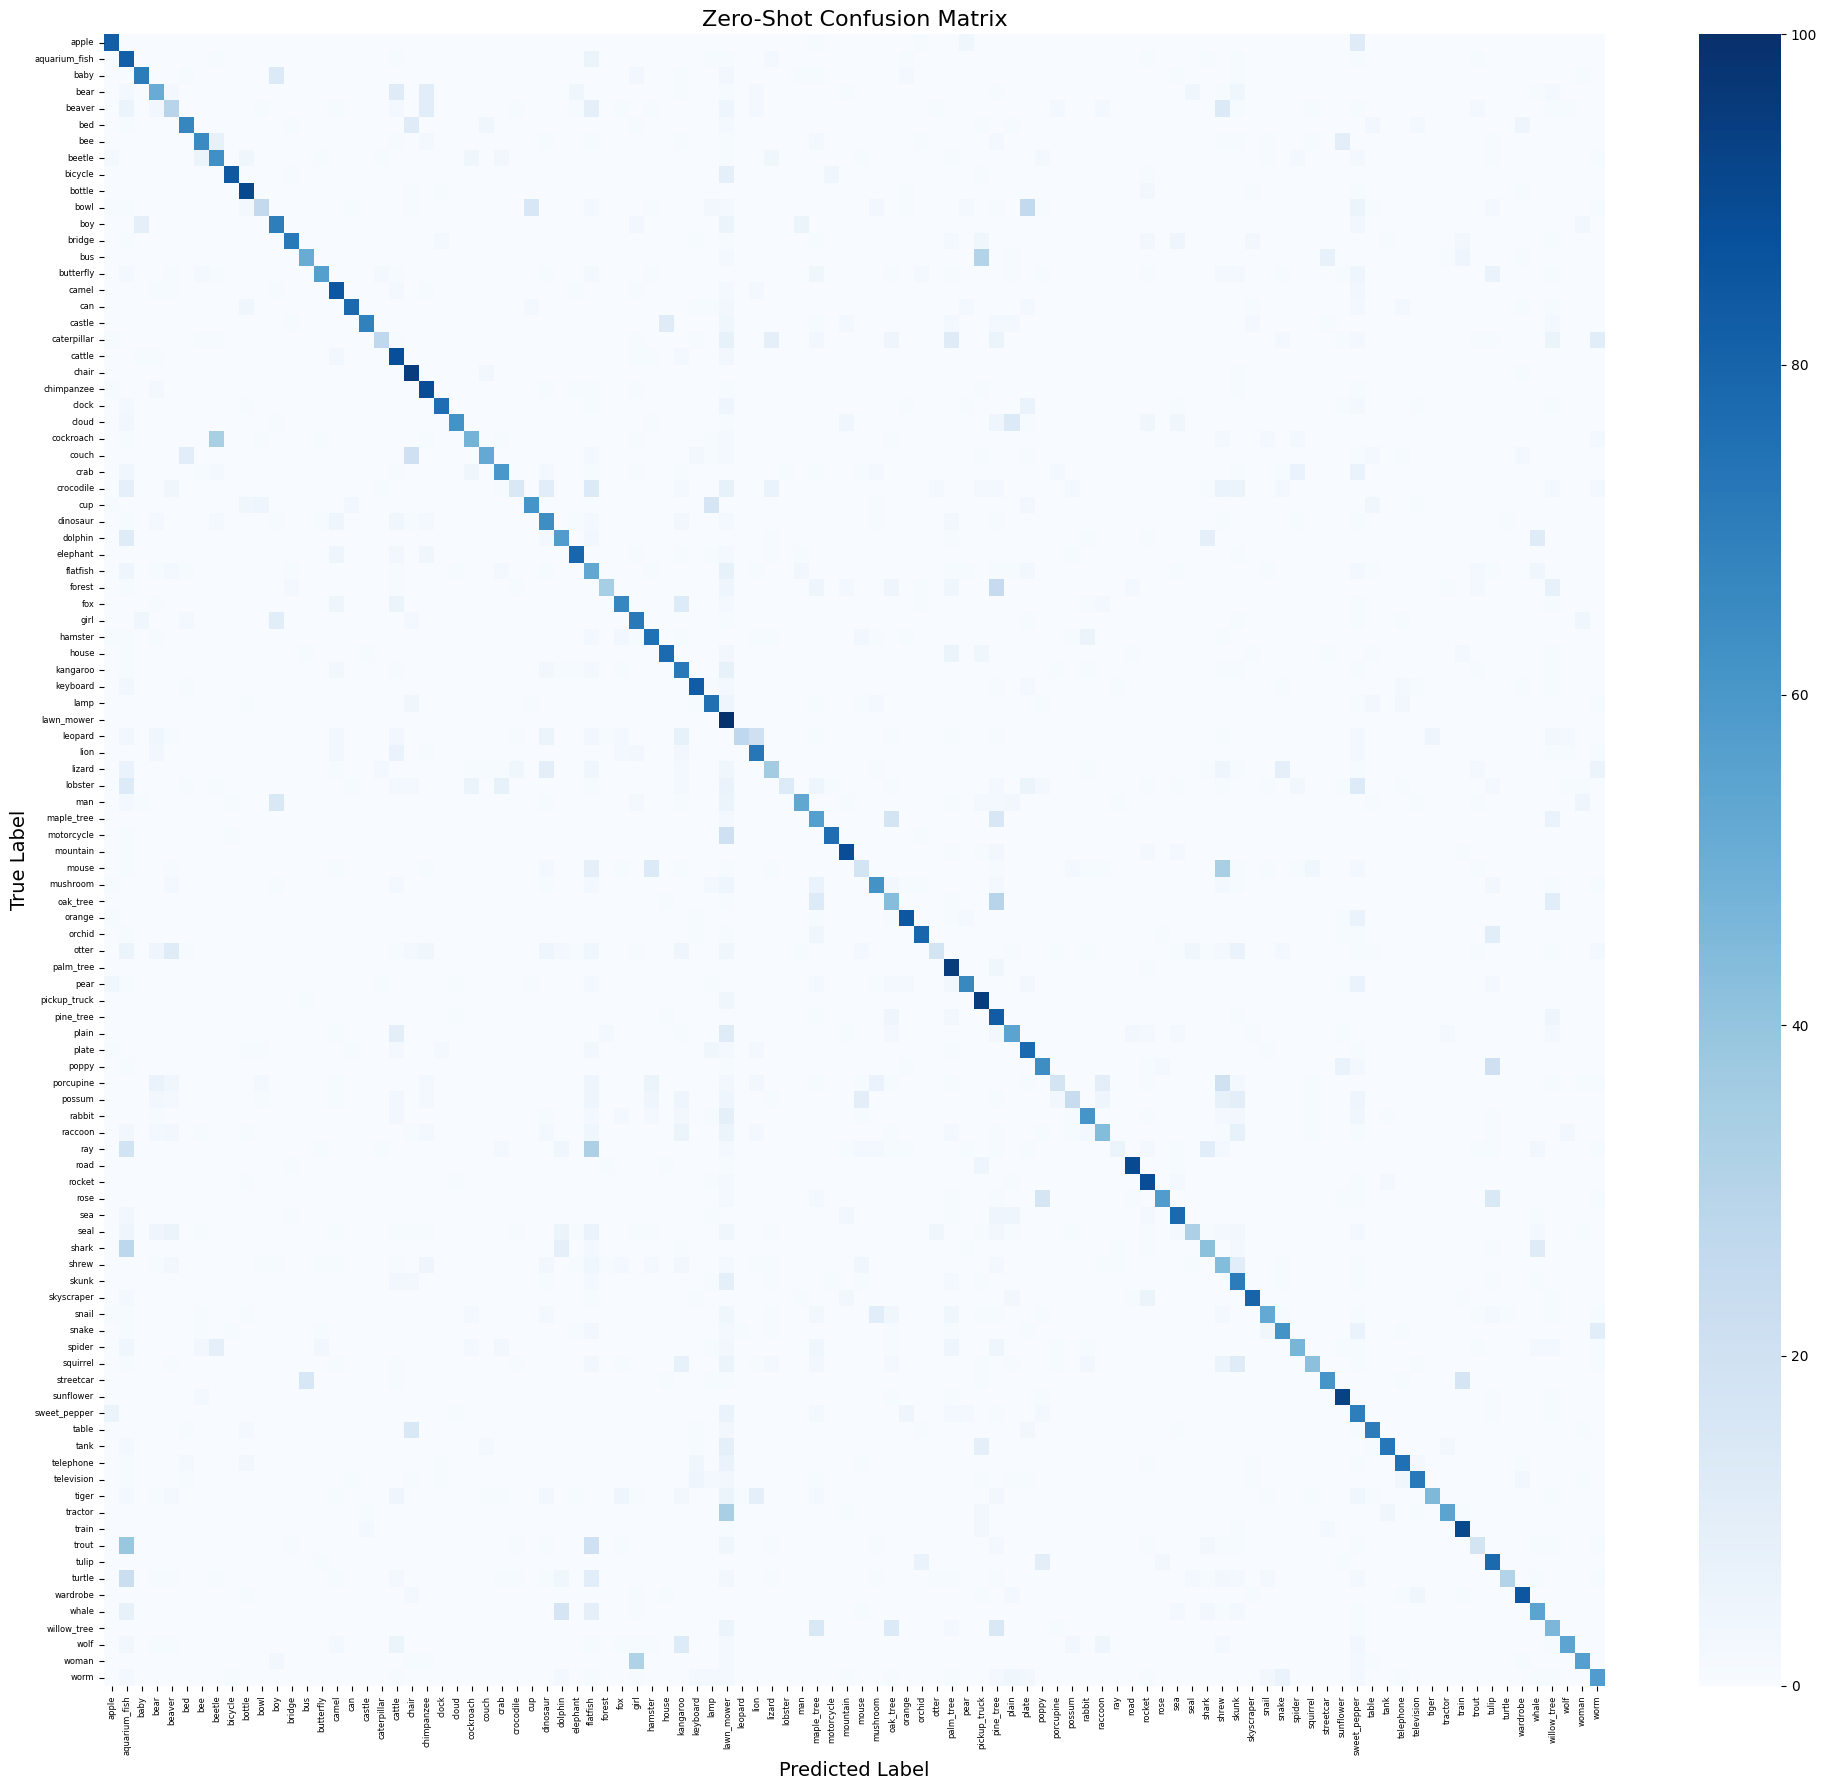

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_labels, zero_shot_preds)
class_names = test_dataset.classes

# Large figure enough to accomodate 100x100 matrix
plt.figure(figsize=(20, 18))

# Plot heatmap without annotations to avoid clutter
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title("Zero-Shot Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()

plt.show()

In [ ]:
# Classification report
print("Classification Report:\n")
print(classification_report(test_labels, zero_shot_preds,
                            target_names=class_names))

Classification Report:

               precision    recall  f1-score   support

        apple       0.80      0.82      0.81       100
aquarium_fish       0.25      0.82      0.39       100
         baby       0.83      0.71      0.76       100
         bear       0.53      0.51      0.52       100
       beaver       0.38      0.30      0.34       100
          bed       0.75      0.67      0.71       100
          bee       0.77      0.65      0.71       100
       beetle       0.51      0.63      0.57       100
      bicycle       0.95      0.84      0.89       100
       bottle       0.78      0.91      0.84       100
         bowl       0.68      0.26      0.38       100
          boy       0.59      0.70      0.64       100
       bridge       0.89      0.72      0.80       100
          bus       0.74      0.51      0.60       100
    butterfly       0.85      0.57      0.68       100
        camel       0.68      0.85      0.76       100
          can       0.92      0.78      

## Zero-shot Final Insights

Confronting the results with the experiment on **CIFAR-10** (see [here](https://colab.research.google.com/drive/1XhteCOnklcn58XBooD8k-hq_gd1ZVjhs?usp=drive_link)) we observe that:

* On **CIFAR-10** CLIP achieves **~88.8%** accuracy without any training, using only image-text similarity;
* On **CIFAR-100** CLIP still performs remarkably well at **61.71%** despite much finer-grained categories and smaller, low-res images (32x32).

This highlights CLIP's semantic power, but also its limits since confusion increases when class labels are more subtle or visually similar and some classes are less represented in CLIP's pretraining distribution.
We're now able to outline that CLIP's embeddings are powerful, a lightweight supervised model can adapt better to dataset-specific decision boundaries, especially in tightly constrained or noisy datasets like **CIFAR**.
